## Toxicity Baseline NB by Sub Categories Seperate vocab
Competition location:  
https://www.kaggle.com/c/jigsaw-unintended-bias-in-toxicity-classification  
https://blog.insightdatascience.com/how-to-solve-90-of-nlp-problems-a-step-by-step-guide-fda605278e4e

In [1]:
import numpy as np
import pandas as pd
import vocab as vocabulary
import collections
import utils
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_fscore_support as score

In [2]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

### Load data

In [3]:
train = pd.read_csv('/data/ToxicityData/train.csv')
test = pd.read_csv('/data/ToxicityData/test.csv')

In [4]:
test.head()

,id,comment_text
0,7000000,Jeff Sessions is another one of Trump's Orwell...
1,7000001,I actually inspected the infrastructure on Gra...
2,7000002,No it won't . That's just wishful thinking on ...
3,7000003,Instead of wringing our hands and nibbling the...
4,7000004,how many of you commenters have garbage piled ...


### Tokenization
This can be as simple as calling string.split() - good enough for English and many European languages - but we could also do something more sophisticated here. There are various types of tokenizers:  
  
1. nltk.tokenize.treebank import TreebankWordTokenizer
2. nltk.tokenize import WhitespaceTokenizer

In [5]:
from nltk.tokenize import WhitespaceTokenizer
white_token = WhitespaceTokenizer()

In [6]:
from keras.preprocessing.text import Tokenizer
keras_token = Tokenizer()

Using TensorFlow backend.


In [7]:
V = 30000
SEED = 23
VAL_SPLIT = 0.3

#### First, tokenize everything to build vocab
Only use vocabs from train data.

In [8]:
from nltk.corpus import stopwords

def check_frequency(data, n = 20):
    stop = stopwords.words('english')
    data  = data.apply(lambda x: " ".join(x.lower() for x in x.split()))
    data = data.str.replace('[^\w\s]','')
    data = data.apply(lambda x: " ".join(x for x in x.split() if x not in stop))
    freq = pd.Series(' '.join(data).split()).value_counts()[:n]
    return freq



### Look at some of the common words for those with high targets

In [9]:
check_frequency(data = train['comment_text'], n = 10)

would     301263
people    299566
one       256929
like      254760
dont      218081
trump     207496
get       196602
us        194333
time      155511
think     149475
dtype: int64

In [10]:
check_frequency(data = train[train['target'] > 0.5]['comment_text'], n = 10)

trump     21314
people    19137
like      17986
stupid    13054
would     12985
dont      12800
one       12589
get       11991
us         8988
think      8155
dtype: int64

In [11]:
check_frequency(data = train[train['severe_toxicity'] > 0.5]['comment_text'], n = 10)

shit      5
kill      5
hate      4
burn      4
time      3
cut       3
white     3
lets      3
like      3
mother    2
dtype: int64

In [12]:
check_frequency(data = train[train['obscene'] > 0.5]['comment_text'], n = 10)

crap      1323
damn      1319
like      1263
people    1236
get       1138
dont      1070
would      902
trump      897
one        868
ass        717
dtype: int64

In [13]:
check_frequency(data = train[train['identity_attack'] > 0.5]['comment_text'], n = 10)

white      3258
black      2325
people     2150
muslims    1323
muslim     1081
like       1076
gay        1014
dont        961
would       907
one         800
dtype: int64

In [14]:
check_frequency(data = train[train['insult'] > 0.5]['comment_text'], n = 10)

trump     17863
like      13927
people    13730
stupid    12464
would      9538
one        9412
dont       9319
get        8813
us         6759
think      6213
dtype: int64

In [15]:
check_frequency(data = train[train['threat'] > 0.5]['comment_text'], n = 10)

kill      726
shoot     351
would     292
people    277
get       272
death     229
like      220
dont      205
one       198
die       198
dtype: int64

In [16]:
check_frequency(data = train[train['sexual_explicit'] > 0.5]['comment_text'], n = 10)

sex       853
ass       568
like      448
get       413
women     402
sexual    382
trump     367
dont      354
one       354
would     345
dtype: int64

In [99]:
## Create a subdataset with most of the errors and build vocab based on that

tokenize_all_one_list = white_token.tokenize(' '.join(train[train['target'] > 0.5]['comment_text'].tolist()))
len(set(tokenize_all_one_list))

# len of full set 1,670,966

232879

In [100]:
collections.Counter(tokenize_all_one_list).most_common(20)

[('the', 189886),
 ('to', 122059),
 ('and', 112481),
 ('a', 105773),
 ('of', 94324),
 ('is', 80576),
 ('in', 55475),
 ('that', 53637),
 ('you', 52376),
 ('are', 44498),
 ('for', 43399),
 ('I', 38945),
 ('be', 28778),
 ('with', 28125),
 ('have', 27602),
 ('on', 27008),
 ('it', 26646),
 ('not', 26585),
 ('this', 25066),
 ('they', 24216)]

In [101]:
collections.Counter(tokenize_all_one_list).most_common(V)[-1]
# compare to before this is a lot less frequent, but still seems reasonable

('24/7,', 7)

#### The 30kth token has 140 appearances, not too bad, we will use top 30k covab, and leave the rest as unknown
This step takes a long time.

In [102]:
vocab = vocabulary.Vocabulary(tokenize_all_one_list, size=30000)

In [103]:
x_train = [vocab.words_to_ids(white_token.tokenize(train_row)) for train_row in train['comment_text'].tolist()]
x_test = [vocab.words_to_ids(white_token.tokenize(test_row)) for test_row in test['comment_text'].tolist()]

In [104]:
y_train = np.array(train['target'] > 0.5)
y_sevtox_train = np.array(train['severe_toxicity'] > 0.5)
y_obs_train = np.array(train['obscene'] > 0.5)
y_idat_train = np.array(train['identity_attack'] > 0.5)
y_ins_train = np.array(train['insult'] > 0.5)
y_thr_train = np.array(train['threat'] > 0.5)
y_expl_train = np.array(train['sexual_explicit'] > 0.5)


In [105]:
y_train = np.array([1 if i else 0 for i in y_train])
y_sevtox_train = np.array([1 if i else 0 for i in y_sevtox_train])
y_obs_train = np.array([1 if i else 0 for i in  y_obs_train])
y_idat_train = np.array([1 if i else 0 for i in y_idat_train])
y_ins_train = np.array([1 if i else 0 for i in  y_ins_train])
y_thr_train = np.array([1 if i else 0 for i in y_thr_train])
y_expl_train = np.array([1 if i else 0 for i in y_expl_train])


## Sub class correlation
### Make all the labels into one matrix
And analyze the correlation between them

This is interesting, target is highly correlated with 'insult'. This is probably because every time insult is high, target is high, meaning that all other categories can be viewed as insult. However, sexual explicit and threat could be different, i.e. for other types of negative comment, these two won't get flagged. 

## Predict by sub categories
Have to divide trainin

In [106]:
rng = np.random.RandomState(SEED)

indices = np.arange(len(x_train))

rng.shuffle(indices)  # in-place

x_train =  np.array(x_train)
y_train =  np.array(y_train)


# the indices slicing only works with np array

x_train_s = x_train[indices]
y_train_s = y_train[indices]

y_sevtox_train_s = y_sevtox_train[indices]
y_obs_train_s = y_obs_train[indices]
y_idat_train_s = y_idat_train[indices]
y_ins_train_s = y_ins_train[indices]
y_thr_train_s = y_thr_train[indices]
y_expl_train_s = y_expl_train[indices]

split_idx = int(VAL_SPLIT * len(x_train))
val_x = x_train_s[:split_idx]
val_y = y_train_s[:split_idx]

val_y_sevtox = y_sevtox_train[:split_idx]
val_y_obs = y_obs_train[:split_idx]
val_y_idat = y_idat_train[:split_idx]
val_y_ins = y_ins_train[:split_idx]
val_y_thr = y_thr_train[:split_idx]
val_y_expl = y_expl_train[:split_idx]

train_x = x_train_s[split_idx:]
train_y  = y_train_s[split_idx:]

train_y_sevtox = y_sevtox_train[split_idx:]
train_y_obs = y_obs_train[split_idx:]
train_y_idat = y_idat_train[split_idx:]
train_y_ins = y_ins_train[split_idx:]
train_y_thr = y_thr_train[split_idx:]
train_y_expl = y_expl_train[split_idx:]


In [107]:
train_x_sb = utils.id_lists_to_sparse_bow(train_x, V)
val_x_sb = utils.id_lists_to_sparse_bow(val_x, V)


### Unlike the previous case, we use 0.3 as the threshhold as determining if a label is toxic (down from 0.5)

#### precision: how many predicted positive are actually positive
#### recall: how much positive cases did you catch (doesn't work as well when large false positive)

In [108]:

nb = MultinomialNB()

print(train_x_sb[3][(0, 5)])
print(train_y[3])
print(val_x_sb[3][(0, 6)])
print(val_y[3])
print(train_x_sb.shape[0])
nb.fit(train_x_sb, train_y)
y_pred_val = nb.predict(val_x_sb)


acc = accuracy_score(val_y, y_pred_val)
print("Accuracy on test set: {:.02%}".format(acc))

precision, recall, fscore, support = score(val_y, y_pred_val)
print('precision: {}'.format(precision))
print('recall: {}'.format(recall))
print('fscore: {}'.format(fscore))
print('support: {}'.format(support))

6
0
3
1
1263412
Accuracy on test set: 91.34%
precision: [0.97551944 0.36198501]
recall: [0.93136564 0.62491735]
fscore: [0.95293135 0.45842572]
support: [509701  31761]


In [109]:
nb_sevtox = MultinomialNB()
nb_sevtox.fit(train_x_sb, train_y_sevtox)
y_pred_val_sevtox = nb.predict(val_x_sb)


acc_sevtox = accuracy_score(val_y_sevtox, y_pred_val_sevtox)
print("Accuracy on test set severe_toxicity: {:.02%}".format(acc_sevtox))

precision, recall, fscore, support = score(val_y_sevtox, y_pred_val_sevtox)
print('precision: {}'.format(precision))
print('recall: {}'.format(recall))
print('fscore: {}'.format(fscore))
print('support: {}'.format(support))

Accuracy on test set severe_toxicity: 89.87%
precision: [1.00000000e+00 1.82378581e-05]
recall: [0.89873694 1.        ]
fscore: [9.46668197e-01 3.64750511e-05]
support: [541461      1]


In [110]:
nb_obs = MultinomialNB()
nb_obs.fit(train_x_sb, train_y_obs)
y_pred_val_obs = nb.predict(val_x_sb)


acc_obs = accuracy_score(val_y_obs, y_pred_val_obs)
print("Accuracy on test set obscene: {:.02%}".format(acc_obs))

precision, recall, fscore, support = score(val_y_obs, y_pred_val_obs)
print('precision: {}'.format(precision))
print('recall: {}'.format(recall))
print('fscore: {}'.format(fscore))
print('support: {}'.format(support))

Accuracy on test set obscene: 89.47%
precision: [0.99492223 0.00514308]
recall: [0.89874125 0.10243371]
fscore: [0.94438918 0.00979439]
support: [538709   2753]


In [111]:
nb_idat = MultinomialNB()
nb_idat.fit(train_x_sb, train_y_idat)
y_pred_val_idat = nb.predict(val_x_sb)


acc_idat = accuracy_score(val_y_idat, y_pred_val_idat)
print("Accuracy on test set identity_attack: {:.02%}".format(acc_idat))

precision, recall, fscore, support = score(val_y_idat, y_pred_val_idat)
print('precision: {}'.format(precision))
print('recall: {}'.format(recall))
print('fscore: {}'.format(fscore))
print('support: {}'.format(support))

Accuracy on test set identity_attack: 89.59%
precision: [0.99639768 0.00351991]
recall: [0.89872775 0.0991778 ]
fscore: [0.94504589 0.00679853]
support: [539516   1946]


In [112]:
nb_ins = MultinomialNB()
nb_ins.fit(train_x_sb, train_y_ins)
y_pred_val_ins = nb.predict(val_x_sb)


acc_ins = accuracy_score(val_y_ins, y_pred_val_ins)
print("Accuracy on test set insult: {:.02%}".format(acc_ins))

precision, recall, fscore, support = score(val_y_ins, y_pred_val_ins)
print('precision: {}'.format(precision))
print('recall: {}'.format(recall))
print('fscore: {}'.format(fscore))
print('support: {}'.format(support))

Accuracy on test set insult: 86.35%
precision: [0.9557036  0.04552169]
recall: [0.89885197 0.10377515]
fscore: [0.92640639 0.0632836 ]
support: [517410  24052]


In [113]:
nb_thr = MultinomialNB()
nb_thr.fit(train_x_sb, train_y_thr)
y_pred_val_thr = nb.predict(val_x_sb)


acc_thr = accuracy_score(val_y_thr, y_pred_val_thr)
print("Accuracy on test set threat: {:.02%}".format(acc_thr))

precision, recall, fscore, support = score(val_y_thr, y_pred_val_thr)
print('precision: {}'.format(precision))
print('recall: {}'.format(recall))
print('fscore: {}'.format(fscore))
print('support: {}'.format(support))

Accuracy on test set threat: 89.74%
precision: [0.99837043 0.00175083]
recall: [0.89874633 0.1079865 ]
fscore: [0.94594258 0.0034458 ]
support: [540573    889]


In [114]:
nb_expl = MultinomialNB()
nb_expl.fit(train_x_sb, train_y_expl)
y_pred_val_expl = nb.predict(val_x_sb)


acc_expl = accuracy_score(val_y_expl, y_pred_val_expl)
print("Accuracy on test set sexual_explicit: {:.02%}".format(acc_expl))

precision, recall, fscore, support = score(val_y_expl, y_pred_val_expl)
print('precision: {}'.format(precision))
print('recall: {}'.format(recall))
print('fscore: {}'.format(fscore))
print('support: {}'.format(support))

Accuracy on test set sexual_explicit: 89.72%
precision: [0.99808479 0.00176907]
recall: [0.89872195 0.09426628]
fscore: [0.94580085 0.00347297]
support: [540433   1029]


We can see that most of the problems are insults. And that even though predicted accuracy is high, the precision is rather terrible, meaning that most of our predicted 'toxic comments' are not really toxic.

In [115]:
# https://github.com/hundredblocks/concrete_NLP_tutorial
# modified to work with current set up

def get_most_important_features(vocab, model, n=5):
    
    # loop for each class
    classes ={}
    stop = stopwords.words('english')  
    
    for class_index in range(model.coef_.shape[0]):
        
     
        word_importances = [(np.exp(el), vocab.ids_to_words([i])) for i,el in enumerate(model.coef_[class_index])
                            if vocab.ids_to_words([i])[0].lower() not in stop]
        
        sorted_coeff = sorted(word_importances, key = lambda x : x[0], reverse=True)
        tops = sorted(sorted_coeff[:n], key = lambda x : x[0])
        bottom = sorted_coeff[-n:]
        classes[class_index] = {
            'tops':tops,
            'bottom':bottom
        }
        
    return classes


In [116]:
'the' in stopwords.words('english') 

True

In [117]:
importance = get_most_important_features(vocab, nb, 10)

In [118]:
# https://github.com/hundredblocks/concrete_NLP_tutorial
def plot_important_words(top_scores, top_words, bottom_scores, bottom_words, name):
    y_pos = np.arange(len(top_words))
    top_pairs = [(a,b) for a,b in zip(top_words, top_scores)]
    top_pairs = sorted(top_pairs, key=lambda x: x[1])
    
    bottom_pairs = [(a,b) for a,b in zip(bottom_words, bottom_scores)]
    bottom_pairs = sorted(bottom_pairs, key=lambda x: x[1], reverse=True)
    
    top_words = [a[0] for a in top_pairs]
    top_scores = [a[1] for a in top_pairs]
    
    bottom_words = [a[0] for a in bottom_pairs]
    bottom_scores = [a[1] for a in bottom_pairs]
    
    fig = plt.figure(figsize=(10, 10))  

    plt.subplot(121)
    plt.barh(y_pos,bottom_scores, align='center', alpha=0.5)
    plt.title('Non-Toxic', fontsize=20)
    plt.yticks(y_pos, bottom_words, fontsize=14)
    plt.suptitle('Key words', fontsize=16)
    plt.xlabel('Importance', fontsize=20)
    
    plt.subplot(122)
    plt.barh(y_pos,top_scores, align='center', alpha=0.5)
    plt.title('Toxic', fontsize=20)
    plt.yticks(y_pos, top_words, fontsize=14)
    plt.suptitle(name, fontsize=16)
    plt.xlabel('Importance', fontsize=20)
    
    plt.subplots_adjust(wspace=0.8)
    plt.show()

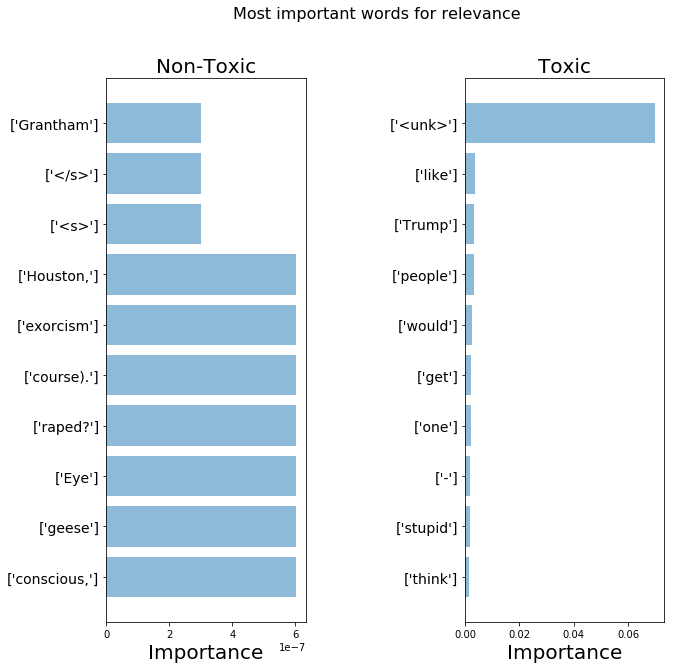

In [119]:
top_scores = [a[0] for a in importance[0]['tops']]
top_words = [a[1] for a in importance[0]['tops']]
bottom_scores = [a[0] for a in importance[0]['bottom']]
bottom_words = [a[1] for a in importance[0]['bottom']]
plot_important_words(top_scores, top_words, bottom_scores, bottom_words, "Most important words for relevance")

In [120]:
def plot_given_model (model):
    importance = get_most_important_features(vocab, model, 10)
    top_scores = [a[0] for a in importance[0]['tops']]
    top_words = [a[1] for a in importance[0]['tops']]
    bottom_scores = [a[0] for a in importance[0]['bottom']]
    bottom_words = [a[1] for a in importance[0]['bottom']]
    plot_important_words(top_scores, top_words, bottom_scores, bottom_words, "Most important words for relevance")

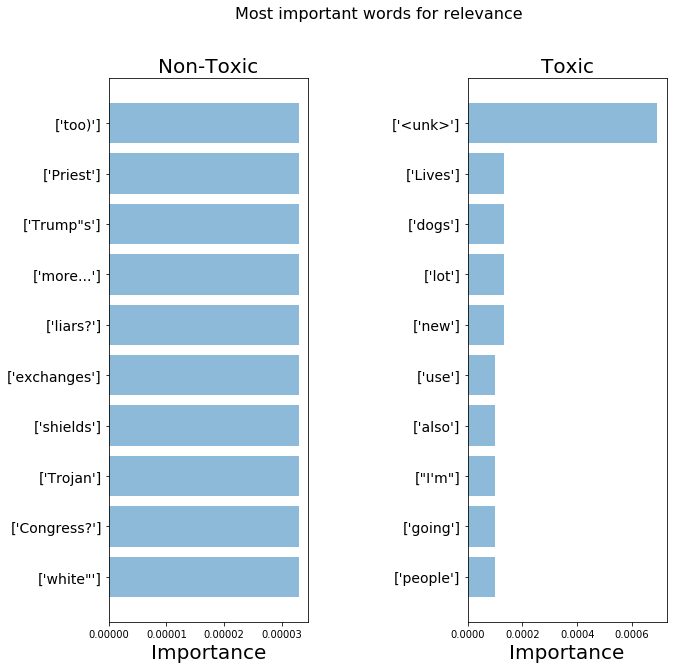

In [121]:
plot_given_model(nb_sevtox)

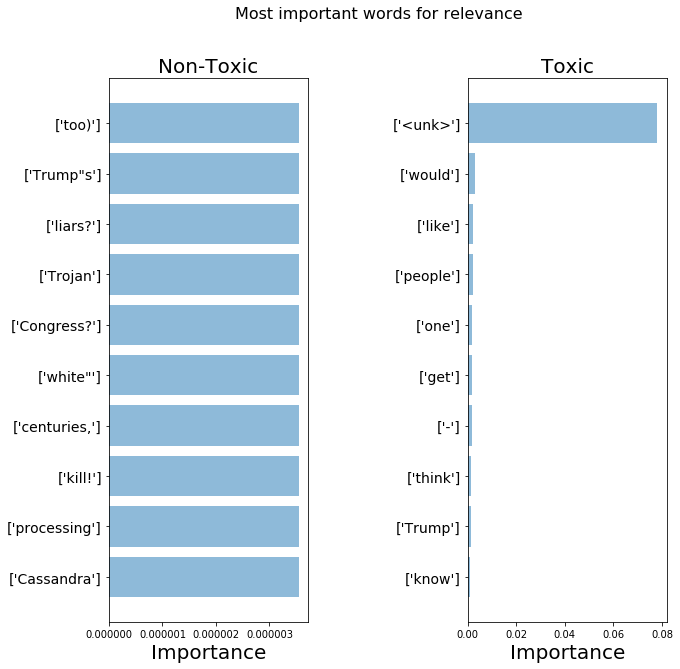

In [122]:
plot_given_model(nb_obs)

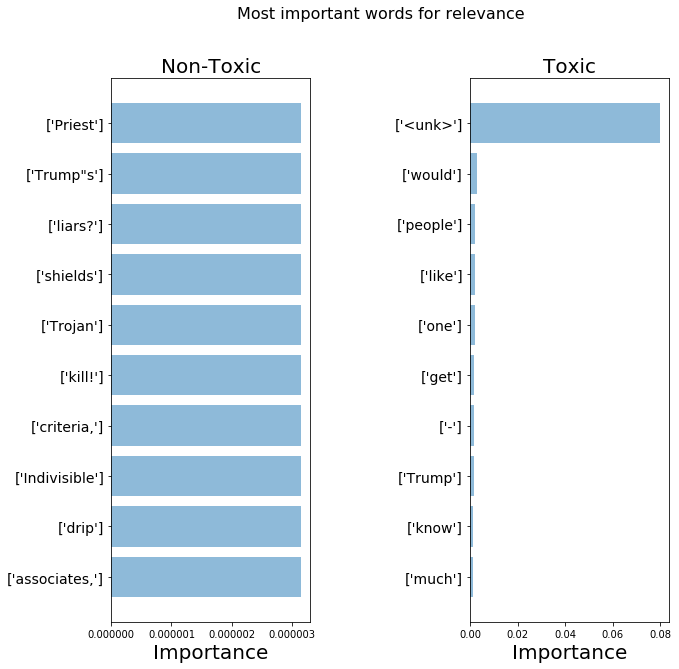

In [123]:
plot_given_model(nb_idat)

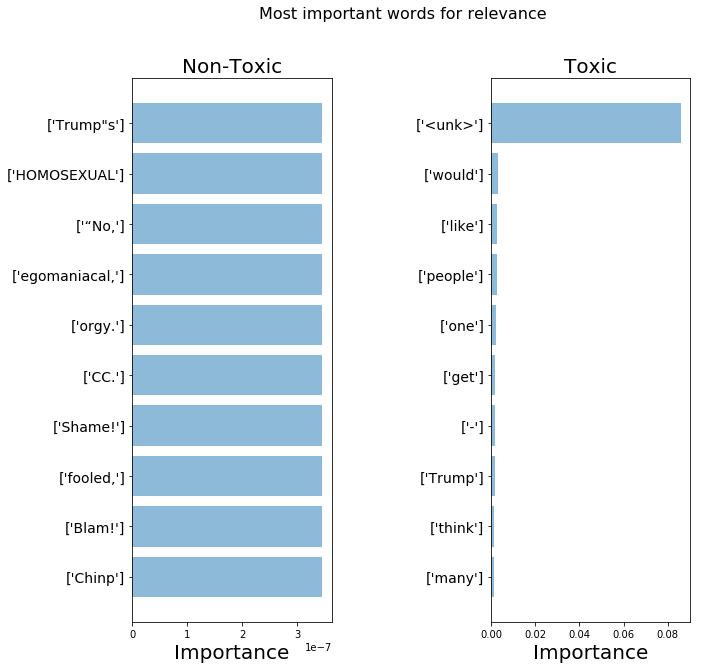

In [124]:
plot_given_model(nb_ins)

## Seems like even with this new vocab, we do not capture the negative words properly
There is something fishy about this